<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-ConorBobbleHat/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [20]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        return train_transform, test_transform

    return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [50]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation, augmentation=augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, train=True, transform=train_transform)
    test_dataset  = torchvision.datasets.FashionMNIST(root='./data', download=True, train=False, transform=test_transform)

    # TODO: create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [55]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2) # Remember that a kernel size and stride of 2 each effectively halves the size of the image!

        if self.useRegularization:
            self.dropout1 = nn.Dropout(dropout_prob)
            self.dropout2 = nn.Dropout(dropout_prob)
            self.dropout3 = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(6272, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit
        if self.useRegularization:
            x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        if self.useRegularization:
            x = self.dropout1(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        if self.useRegularization:
            x = self.dropout1(x)

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [56]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font

*   List item
*   List item

color='green'>(1 point)</font>

In [78]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [79]:
epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.305943  [   32/60000]
loss: 0.621101  [ 3232/60000]
loss: 0.310083  [ 6432/60000]
loss: 0.522960  [ 9632/60000]
loss: 0.274868  [12832/60000]
loss: 0.672764  [16032/60000]
loss: 0.301123  [19232/60000]
loss: 0.281554  [22432/60000]
loss: 0.484229  [25632/60000]
loss: 0.343332  [28832/60000]
loss: 0.535110  [32032/60000]
loss: 0.262598  [35232/60000]
loss: 0.228351  [38432/60000]
loss: 0.405776  [41632/60000]
loss: 0.464117  [44832/60000]
loss: 0.381116  [48032/60000]
loss: 0.097694  [51232/60000]
loss: 0.228928  [54432/60000]
loss: 0.198878  [57632/60000]


Epochs:  20%|██        | 1/5 [00:35<02:23, 35.77s/it]

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.245275 

Test Error: 
 Accuracy: 89.6%, Avg loss: 0.279673 

Epoch 2:

loss: 0.221931  [   32/60000]
loss: 0.143673  [ 3232/60000]
loss: 0.120849  [ 6432/60000]
loss: 0.267257  [ 9632/60000]
loss: 0.072150  [12832/60000]
loss: 0.354815  [16032/60000]
loss: 0.204886  [19232/60000]
loss: 0.241681  [22432/60000]
loss: 0.287259  [25632/60000]
loss: 0.175479  [28832/60000]
loss: 0.522876  [32032/60000]
loss: 0.153818  [35232/60000]
loss: 0.206654  [38432/60000]
loss: 0.275974  [41632/60000]
loss: 0.429399  [44832/60000]
loss: 0.308584  [48032/60000]
loss: 0.074165  [51232/60000]
loss: 0.177141  [54432/60000]
loss: 0.164234  [57632/60000]


Epochs:  40%|████      | 2/5 [01:11<01:47, 35.73s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.187343 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.250419 

Epoch 3:

loss: 0.138212  [   32/60000]
loss: 0.154503  [ 3232/60000]
loss: 0.117750  [ 6432/60000]
loss: 0.235308  [ 9632/60000]
loss: 0.041519  [12832/60000]
loss: 0.251056  [16032/60000]
loss: 0.188394  [19232/60000]
loss: 0.251290  [22432/60000]
loss: 0.254585  [25632/60000]
loss: 0.130534  [28832/60000]
loss: 0.385553  [32032/60000]
loss: 0.099542  [35232/60000]
loss: 0.105928  [38432/60000]
loss: 0.212455  [41632/60000]
loss: 0.285718  [44832/60000]
loss: 0.296465  [48032/60000]
loss: 0.045665  [51232/60000]
loss: 0.137002  [54432/60000]
loss: 0.191154  [57632/60000]


Epochs:  60%|██████    | 3/5 [01:46<01:11, 35.55s/it]

Train Error: 
 Accuracy: 94.4%, Avg loss: 0.149470 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.247339 

Epoch 4:

loss: 0.098136  [   32/60000]
loss: 0.104719  [ 3232/60000]
loss: 0.083414  [ 6432/60000]
loss: 0.234603  [ 9632/60000]
loss: 0.032348  [12832/60000]
loss: 0.147360  [16032/60000]
loss: 0.045897  [19232/60000]
loss: 0.280374  [22432/60000]
loss: 0.156627  [25632/60000]
loss: 0.090133  [28832/60000]
loss: 0.215709  [32032/60000]
loss: 0.143901  [35232/60000]
loss: 0.166704  [38432/60000]
loss: 0.120527  [41632/60000]
loss: 0.188714  [44832/60000]
loss: 0.314381  [48032/60000]
loss: 0.031692  [51232/60000]
loss: 0.233044  [54432/60000]
loss: 0.133026  [57632/60000]


Epochs:  80%|████████  | 4/5 [02:22<00:35, 35.56s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.140485 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.291794 

Epoch 5:

loss: 0.116632  [   32/60000]
loss: 0.079375  [ 3232/60000]
loss: 0.058119  [ 6432/60000]
loss: 0.147018  [ 9632/60000]
loss: 0.011095  [12832/60000]
loss: 0.113154  [16032/60000]
loss: 0.110515  [19232/60000]
loss: 0.180022  [22432/60000]
loss: 0.104627  [25632/60000]
loss: 0.055200  [28832/60000]
loss: 0.166947  [32032/60000]
loss: 0.075296  [35232/60000]
loss: 0.093351  [38432/60000]
loss: 0.141532  [41632/60000]
loss: 0.193337  [44832/60000]
loss: 0.165049  [48032/60000]
loss: 0.016414  [51232/60000]
loss: 0.131804  [54432/60000]
loss: 0.088685  [57632/60000]


Epochs: 100%|██████████| 5/5 [02:58<00:00, 35.61s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.114485 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.299993 

Done training!


Plotting metrics

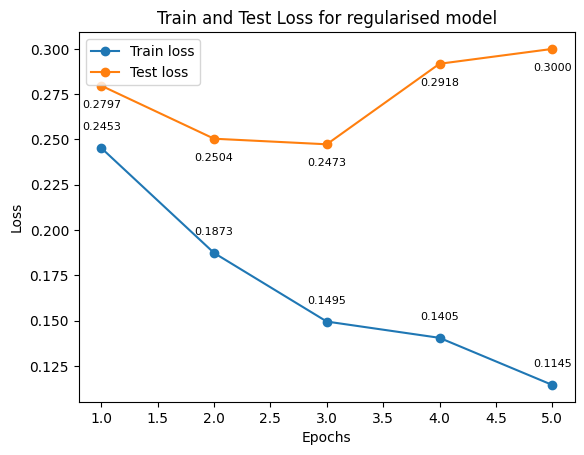

In [80]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

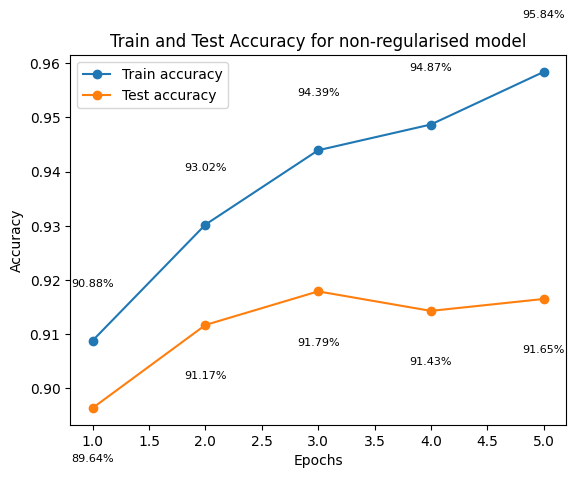

In [81]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [64]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(augmentation=True)

model = model = NetFashion().to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301217  [   32/60000]
loss: 0.977229  [ 3232/60000]
loss: 0.436150  [ 6432/60000]
loss: 0.669664  [ 9632/60000]
loss: 0.298594  [12832/60000]
loss: 0.882248  [16032/60000]
loss: 0.474862  [19232/60000]
loss: 0.279725  [22432/60000]
loss: 0.402891  [25632/60000]
loss: 0.555246  [28832/60000]
loss: 0.483454  [32032/60000]
loss: 0.216650  [35232/60000]
loss: 0.332368  [38432/60000]
loss: 0.487015  [41632/60000]
loss: 0.498568  [44832/60000]
loss: 0.194754  [48032/60000]
loss: 0.231890  [51232/60000]
loss: 0.379938  [54432/60000]
loss: 0.401954  [57632/60000]


Epochs:  10%|█         | 1/10 [00:55<08:21, 55.68s/it]

Train Error: 
 Accuracy: 88.2%, Avg loss: 0.314335 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.321778 

Epoch 2:

loss: 0.233266  [   32/60000]
loss: 0.265149  [ 3232/60000]
loss: 0.163831  [ 6432/60000]
loss: 0.306572  [ 9632/60000]
loss: 0.131159  [12832/60000]
loss: 0.421384  [16032/60000]
loss: 0.278654  [19232/60000]
loss: 0.181861  [22432/60000]
loss: 0.319163  [25632/60000]
loss: 0.442979  [28832/60000]
loss: 0.430653  [32032/60000]
loss: 0.336909  [35232/60000]
loss: 0.247263  [38432/60000]
loss: 0.264108  [41632/60000]
loss: 0.499544  [44832/60000]
loss: 0.234681  [48032/60000]
loss: 0.207555  [51232/60000]
loss: 0.330034  [54432/60000]
loss: 0.260275  [57632/60000]


Epochs:  20%|██        | 2/10 [01:47<07:08, 53.52s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.236028 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.252337 

Epoch 3:

loss: 0.160848  [   32/60000]
loss: 0.222847  [ 3232/60000]
loss: 0.114769  [ 6432/60000]
loss: 0.288287  [ 9632/60000]
loss: 0.101492  [12832/60000]
loss: 0.262495  [16032/60000]
loss: 0.345729  [19232/60000]
loss: 0.258926  [22432/60000]
loss: 0.224811  [25632/60000]
loss: 0.323259  [28832/60000]
loss: 0.285659  [32032/60000]
loss: 0.289392  [35232/60000]
loss: 0.179092  [38432/60000]
loss: 0.201627  [41632/60000]
loss: 0.450445  [44832/60000]
loss: 0.193102  [48032/60000]
loss: 0.117629  [51232/60000]
loss: 0.334691  [54432/60000]
loss: 0.286142  [57632/60000]


Epochs:  30%|███       | 3/10 [02:40<06:12, 53.23s/it]

Train Error: 
 Accuracy: 92.3%, Avg loss: 0.206895 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.233256 

Epoch 4:

loss: 0.149915  [   32/60000]
loss: 0.211040  [ 3232/60000]
loss: 0.119812  [ 6432/60000]
loss: 0.256885  [ 9632/60000]
loss: 0.078113  [12832/60000]
loss: 0.377375  [16032/60000]
loss: 0.173799  [19232/60000]
loss: 0.191516  [22432/60000]
loss: 0.330896  [25632/60000]
loss: 0.291315  [28832/60000]
loss: 0.420234  [32032/60000]
loss: 0.221669  [35232/60000]
loss: 0.267644  [38432/60000]
loss: 0.302719  [41632/60000]
loss: 0.306426  [44832/60000]
loss: 0.270793  [48032/60000]
loss: 0.133593  [51232/60000]
loss: 0.173920  [54432/60000]
loss: 0.214049  [57632/60000]


Epochs:  40%|████      | 4/10 [03:32<05:16, 52.77s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.189146 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.219570 

Epoch 5:

loss: 0.105609  [   32/60000]
loss: 0.222381  [ 3232/60000]
loss: 0.199271  [ 6432/60000]
loss: 0.242529  [ 9632/60000]
loss: 0.137387  [12832/60000]
loss: 0.448369  [16032/60000]
loss: 0.260936  [19232/60000]
loss: 0.142466  [22432/60000]
loss: 0.183200  [25632/60000]
loss: 0.437486  [28832/60000]
loss: 0.429929  [32032/60000]
loss: 0.200978  [35232/60000]
loss: 0.101254  [38432/60000]
loss: 0.232444  [41632/60000]
loss: 0.269439  [44832/60000]
loss: 0.187179  [48032/60000]
loss: 0.240669  [51232/60000]
loss: 0.119668  [54432/60000]
loss: 0.129433  [57632/60000]


Epochs:  50%|█████     | 5/10 [04:24<04:22, 52.53s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.185924 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.223855 

Epoch 6:

loss: 0.136706  [   32/60000]
loss: 0.127245  [ 3232/60000]
loss: 0.133403  [ 6432/60000]
loss: 0.208061  [ 9632/60000]
loss: 0.071952  [12832/60000]
loss: 0.303276  [16032/60000]
loss: 0.222039  [19232/60000]
loss: 0.161934  [22432/60000]
loss: 0.184211  [25632/60000]
loss: 0.334343  [28832/60000]
loss: 0.161170  [32032/60000]
loss: 0.223605  [35232/60000]
loss: 0.171639  [38432/60000]
loss: 0.220190  [41632/60000]
loss: 0.244906  [44832/60000]
loss: 0.285839  [48032/60000]
loss: 0.067091  [51232/60000]
loss: 0.117204  [54432/60000]
loss: 0.108282  [57632/60000]


Epochs:  60%|██████    | 6/10 [05:16<03:29, 52.40s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.177447 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.227701 

Epoch 7:

loss: 0.246947  [   32/60000]
loss: 0.057217  [ 3232/60000]
loss: 0.125686  [ 6432/60000]
loss: 0.254201  [ 9632/60000]
loss: 0.036886  [12832/60000]
loss: 0.395315  [16032/60000]
loss: 0.102056  [19232/60000]
loss: 0.213712  [22432/60000]
loss: 0.122019  [25632/60000]
loss: 0.261301  [28832/60000]
loss: 0.389829  [32032/60000]
loss: 0.248399  [35232/60000]
loss: 0.099881  [38432/60000]
loss: 0.247025  [41632/60000]
loss: 0.164224  [44832/60000]
loss: 0.185367  [48032/60000]
loss: 0.121612  [51232/60000]
loss: 0.124212  [54432/60000]
loss: 0.134272  [57632/60000]


Epochs:  70%|███████   | 7/10 [06:09<02:37, 52.58s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.165952 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.217091 

Epoch 8:

loss: 0.083633  [   32/60000]
loss: 0.168963  [ 3232/60000]
loss: 0.172594  [ 6432/60000]
loss: 0.307685  [ 9632/60000]
loss: 0.095041  [12832/60000]
loss: 0.239591  [16032/60000]
loss: 0.114856  [19232/60000]
loss: 0.192242  [22432/60000]
loss: 0.111981  [25632/60000]
loss: 0.219001  [28832/60000]
loss: 0.348712  [32032/60000]
loss: 0.329721  [35232/60000]
loss: 0.129075  [38432/60000]
loss: 0.185560  [41632/60000]
loss: 0.211754  [44832/60000]
loss: 0.239518  [48032/60000]
loss: 0.132266  [51232/60000]
loss: 0.239407  [54432/60000]
loss: 0.057115  [57632/60000]


Epochs:  80%|████████  | 8/10 [07:02<01:45, 52.52s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.156149 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.223727 

Epoch 9:

loss: 0.125386  [   32/60000]
loss: 0.156670  [ 3232/60000]
loss: 0.128489  [ 6432/60000]
loss: 0.154289  [ 9632/60000]
loss: 0.074500  [12832/60000]
loss: 0.463504  [16032/60000]
loss: 0.080636  [19232/60000]
loss: 0.182176  [22432/60000]
loss: 0.149651  [25632/60000]
loss: 0.158910  [28832/60000]
loss: 0.196396  [32032/60000]
loss: 0.129202  [35232/60000]
loss: 0.078356  [38432/60000]
loss: 0.303413  [41632/60000]
loss: 0.131067  [44832/60000]
loss: 0.106308  [48032/60000]
loss: 0.118733  [51232/60000]
loss: 0.171353  [54432/60000]
loss: 0.076111  [57632/60000]


Epochs:  90%|█████████ | 9/10 [07:54<00:52, 52.45s/it]

Train Error: 
 Accuracy: 94.1%, Avg loss: 0.160336 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.224295 

Epoch 10:

loss: 0.031367  [   32/60000]
loss: 0.240122  [ 3232/60000]
loss: 0.039946  [ 6432/60000]
loss: 0.277474  [ 9632/60000]
loss: 0.058749  [12832/60000]
loss: 0.158411  [16032/60000]
loss: 0.151144  [19232/60000]
loss: 0.150758  [22432/60000]
loss: 0.092245  [25632/60000]
loss: 0.302824  [28832/60000]
loss: 0.388503  [32032/60000]
loss: 0.249424  [35232/60000]
loss: 0.064464  [38432/60000]
loss: 0.110380  [41632/60000]
loss: 0.335553  [44832/60000]
loss: 0.238157  [48032/60000]
loss: 0.093282  [51232/60000]
loss: 0.075725  [54432/60000]
loss: 0.051602  [57632/60000]


Epochs: 100%|██████████| 10/10 [08:46<00:00, 52.69s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.155401 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.242466 

Done training!


Plotting metrics

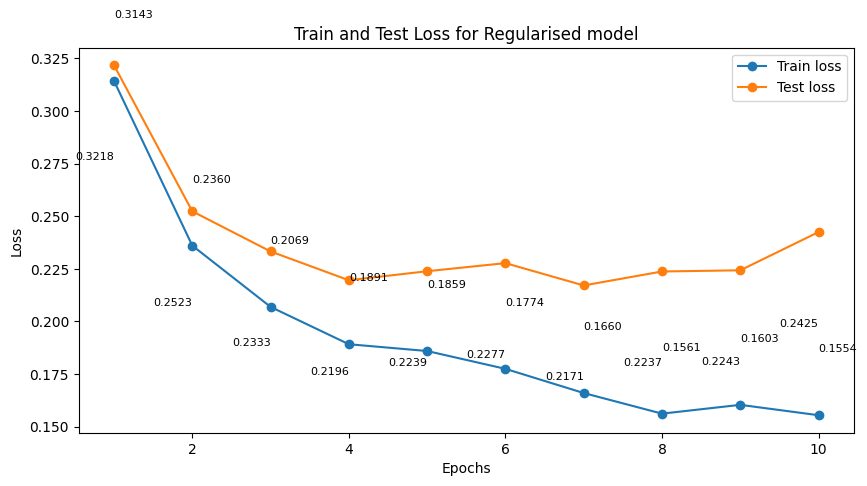

In [65]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

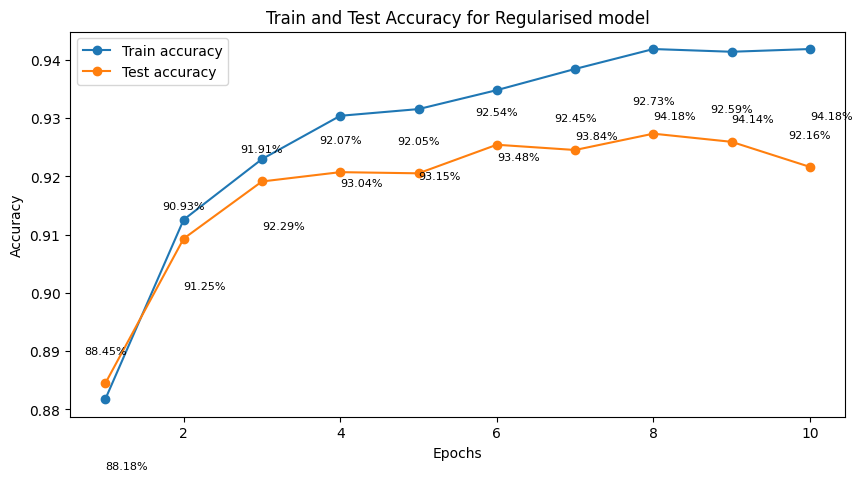

In [66]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [67]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(augmentation=False)

model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.309479  [   32/60000]
loss: 0.598627  [ 3232/60000]
loss: 0.372447  [ 6432/60000]
loss: 0.686701  [ 9632/60000]
loss: 0.258163  [12832/60000]
loss: 0.557076  [16032/60000]
loss: 0.321052  [19232/60000]
loss: 0.231882  [22432/60000]
loss: 0.633326  [25632/60000]
loss: 0.425946  [28832/60000]
loss: 0.604808  [32032/60000]
loss: 0.202389  [35232/60000]
loss: 0.318691  [38432/60000]
loss: 0.582695  [41632/60000]
loss: 0.519211  [44832/60000]
loss: 0.256272  [48032/60000]
loss: 0.157899  [51232/60000]
loss: 0.355277  [54432/60000]
loss: 0.150721  [57632/60000]


Epochs:  10%|█         | 1/10 [00:36<05:32, 36.96s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.264549 

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.293694 

Epoch 2:

loss: 0.208750  [   32/60000]
loss: 0.320230  [ 3232/60000]
loss: 0.205325  [ 6432/60000]
loss: 0.285483  [ 9632/60000]
loss: 0.157998  [12832/60000]
loss: 0.386833  [16032/60000]
loss: 0.295945  [19232/60000]
loss: 0.267724  [22432/60000]
loss: 0.346096  [25632/60000]
loss: 0.390650  [28832/60000]
loss: 0.568229  [32032/60000]
loss: 0.236136  [35232/60000]
loss: 0.353627  [38432/60000]
loss: 0.459935  [41632/60000]
loss: 0.411346  [44832/60000]
loss: 0.345376  [48032/60000]
loss: 0.089582  [51232/60000]
loss: 0.397902  [54432/60000]
loss: 0.269262  [57632/60000]


Epochs:  20%|██        | 2/10 [01:13<04:54, 36.87s/it]

Train Error: 
 Accuracy: 92.1%, Avg loss: 0.210442 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.250709 

Epoch 3:

loss: 0.201865  [   32/60000]
loss: 0.187477  [ 3232/60000]
loss: 0.159616  [ 6432/60000]
loss: 0.284080  [ 9632/60000]
loss: 0.107958  [12832/60000]
loss: 0.309044  [16032/60000]
loss: 0.451571  [19232/60000]
loss: 0.202948  [22432/60000]
loss: 0.353646  [25632/60000]
loss: 0.202231  [28832/60000]
loss: 0.520826  [32032/60000]
loss: 0.112380  [35232/60000]
loss: 0.207870  [38432/60000]
loss: 0.255881  [41632/60000]
loss: 0.271838  [44832/60000]
loss: 0.392723  [48032/60000]
loss: 0.237174  [51232/60000]
loss: 0.207156  [54432/60000]
loss: 0.117269  [57632/60000]


Epochs:  30%|███       | 3/10 [01:50<04:17, 36.77s/it]

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.178818 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.236030 

Epoch 4:

loss: 0.199303  [   32/60000]
loss: 0.185431  [ 3232/60000]
loss: 0.146807  [ 6432/60000]
loss: 0.337830  [ 9632/60000]
loss: 0.091180  [12832/60000]
loss: 0.517416  [16032/60000]
loss: 0.339753  [19232/60000]
loss: 0.235547  [22432/60000]
loss: 0.232100  [25632/60000]
loss: 0.173991  [28832/60000]
loss: 0.298720  [32032/60000]
loss: 0.148662  [35232/60000]
loss: 0.279073  [38432/60000]
loss: 0.391060  [41632/60000]
loss: 0.401850  [44832/60000]
loss: 0.290611  [48032/60000]
loss: 0.192805  [51232/60000]
loss: 0.212543  [54432/60000]
loss: 0.215578  [57632/60000]


Epochs:  40%|████      | 4/10 [02:26<03:40, 36.67s/it]

Train Error: 
 Accuracy: 94.1%, Avg loss: 0.158237 

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.226418 

Epoch 5:

loss: 0.198948  [   32/60000]
loss: 0.178943  [ 3232/60000]
loss: 0.186218  [ 6432/60000]
loss: 0.291934  [ 9632/60000]
loss: 0.080536  [12832/60000]
loss: 0.435765  [16032/60000]
loss: 0.302655  [19232/60000]
loss: 0.268310  [22432/60000]
loss: 0.168784  [25632/60000]
loss: 0.178114  [28832/60000]
loss: 0.382962  [32032/60000]
loss: 0.244881  [35232/60000]
loss: 0.153428  [38432/60000]
loss: 0.270899  [41632/60000]
loss: 0.290119  [44832/60000]
loss: 0.222036  [48032/60000]
loss: 0.244208  [51232/60000]
loss: 0.315203  [54432/60000]
loss: 0.202453  [57632/60000]


Epochs:  50%|█████     | 5/10 [03:03<03:03, 36.65s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.154128 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.225872 

Epoch 6:

loss: 0.151789  [   32/60000]
loss: 0.270621  [ 3232/60000]
loss: 0.076398  [ 6432/60000]
loss: 0.179619  [ 9632/60000]
loss: 0.089877  [12832/60000]
loss: 0.260449  [16032/60000]
loss: 0.186129  [19232/60000]
loss: 0.210491  [22432/60000]
loss: 0.215538  [25632/60000]
loss: 0.072595  [28832/60000]
loss: 0.310658  [32032/60000]
loss: 0.126415  [35232/60000]
loss: 0.131807  [38432/60000]
loss: 0.354652  [41632/60000]
loss: 0.384401  [44832/60000]
loss: 0.302662  [48032/60000]
loss: 0.159488  [51232/60000]
loss: 0.238884  [54432/60000]
loss: 0.213300  [57632/60000]


Epochs:  60%|██████    | 6/10 [03:40<02:26, 36.66s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.126091 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.208360 

Epoch 7:

loss: 0.121214  [   32/60000]
loss: 0.214004  [ 3232/60000]
loss: 0.219183  [ 6432/60000]
loss: 0.144185  [ 9632/60000]
loss: 0.044303  [12832/60000]
loss: 0.317118  [16032/60000]
loss: 0.203892  [19232/60000]
loss: 0.135339  [22432/60000]
loss: 0.544508  [25632/60000]
loss: 0.154656  [28832/60000]
loss: 0.246834  [32032/60000]
loss: 0.092048  [35232/60000]
loss: 0.135137  [38432/60000]
loss: 0.231843  [41632/60000]
loss: 0.217892  [44832/60000]
loss: 0.238851  [48032/60000]
loss: 0.169145  [51232/60000]
loss: 0.165660  [54432/60000]
loss: 0.152988  [57632/60000]


Epochs:  70%|███████   | 7/10 [04:16<01:49, 36.63s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.126670 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.220550 

Epoch 8:

loss: 0.127862  [   32/60000]
loss: 0.203353  [ 3232/60000]
loss: 0.178761  [ 6432/60000]
loss: 0.175938  [ 9632/60000]
loss: 0.045318  [12832/60000]
loss: 0.246521  [16032/60000]
loss: 0.125048  [19232/60000]
loss: 0.146266  [22432/60000]
loss: 0.182046  [25632/60000]
loss: 0.363063  [28832/60000]
loss: 0.194847  [32032/60000]
loss: 0.147624  [35232/60000]
loss: 0.195790  [38432/60000]
loss: 0.140373  [41632/60000]
loss: 0.239493  [44832/60000]
loss: 0.212551  [48032/60000]
loss: 0.129210  [51232/60000]
loss: 0.093084  [54432/60000]
loss: 0.197058  [57632/60000]


Epochs:  80%|████████  | 8/10 [04:53<01:13, 36.72s/it]

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.108415 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.216312 

Epoch 9:

loss: 0.140368  [   32/60000]
loss: 0.200443  [ 3232/60000]
loss: 0.181546  [ 6432/60000]
loss: 0.332774  [ 9632/60000]
loss: 0.043519  [12832/60000]
loss: 0.205290  [16032/60000]
loss: 0.136524  [19232/60000]
loss: 0.123587  [22432/60000]
loss: 0.203688  [25632/60000]
loss: 0.108104  [28832/60000]
loss: 0.215839  [32032/60000]
loss: 0.166822  [35232/60000]
loss: 0.117778  [38432/60000]
loss: 0.425238  [41632/60000]
loss: 0.239146  [44832/60000]
loss: 0.214754  [48032/60000]
loss: 0.117990  [51232/60000]
loss: 0.237916  [54432/60000]
loss: 0.144538  [57632/60000]


Epochs:  90%|█████████ | 9/10 [05:30<00:36, 36.79s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.110066 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.226370 

Epoch 10:

loss: 0.101804  [   32/60000]
loss: 0.148240  [ 3232/60000]
loss: 0.088502  [ 6432/60000]
loss: 0.096927  [ 9632/60000]
loss: 0.014185  [12832/60000]
loss: 0.184534  [16032/60000]
loss: 0.161095  [19232/60000]
loss: 0.144651  [22432/60000]
loss: 0.144587  [25632/60000]
loss: 0.311559  [28832/60000]
loss: 0.139188  [32032/60000]
loss: 0.219865  [35232/60000]
loss: 0.273109  [38432/60000]
loss: 0.151898  [41632/60000]
loss: 0.343254  [44832/60000]
loss: 0.209580  [48032/60000]
loss: 0.253104  [51232/60000]
loss: 0.258297  [54432/60000]
loss: 0.127912  [57632/60000]


Epochs: 100%|██████████| 10/10 [06:07<00:00, 36.72s/it]

Train Error: 
 Accuracy: 96.1%, Avg loss: 0.105907 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.233558 

Done training!


Plotting metrics

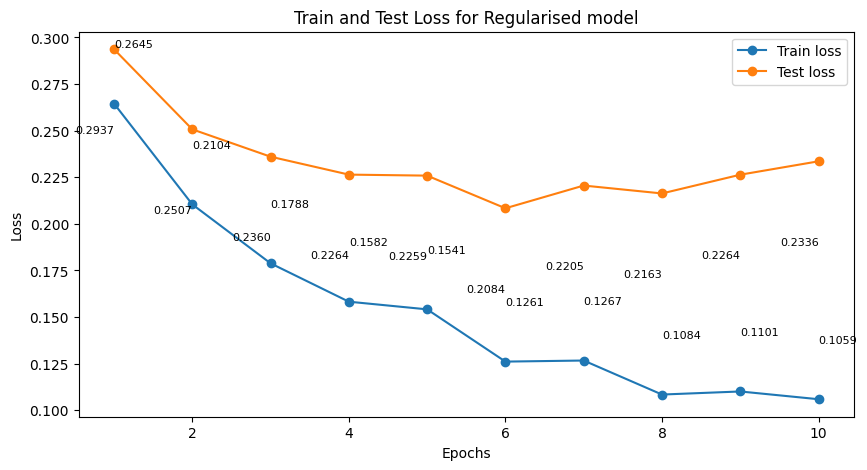

In [68]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

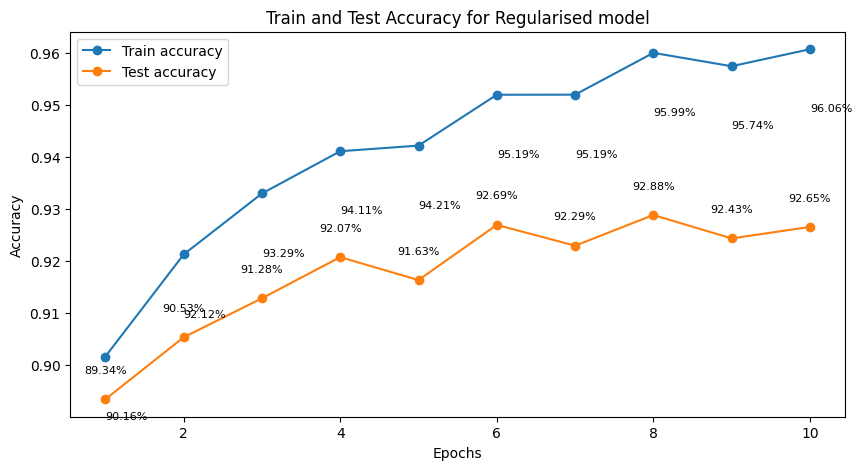

In [69]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [70]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(augmentation=False)

model = NetFashion(useRegularization=False).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300106  [   32/60000]
loss: 0.612760  [ 3232/60000]
loss: 0.340699  [ 6432/60000]
loss: 0.532629  [ 9632/60000]
loss: 0.245103  [12832/60000]
loss: 0.823332  [16032/60000]
loss: 0.284337  [19232/60000]
loss: 0.306367  [22432/60000]
loss: 0.580852  [25632/60000]
loss: 0.308633  [28832/60000]
loss: 0.562162  [32032/60000]
loss: 0.205262  [35232/60000]
loss: 0.273828  [38432/60000]
loss: 0.427912  [41632/60000]
loss: 0.430081  [44832/60000]
loss: 0.427022  [48032/60000]
loss: 0.146324  [51232/60000]
loss: 0.288775  [54432/60000]
loss: 0.202672  [57632/60000]


Epochs:  10%|█         | 1/10 [00:36<05:31, 36.80s/it]

Train Error: 
 Accuracy: 91.1%, Avg loss: 0.237778 

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.275408 

Epoch 2:

loss: 0.190808  [   32/60000]
loss: 0.226387  [ 3232/60000]
loss: 0.146620  [ 6432/60000]
loss: 0.355393  [ 9632/60000]
loss: 0.089936  [12832/60000]
loss: 0.337386  [16032/60000]
loss: 0.226691  [19232/60000]
loss: 0.254227  [22432/60000]
loss: 0.376894  [25632/60000]
loss: 0.170186  [28832/60000]
loss: 0.485421  [32032/60000]
loss: 0.132103  [35232/60000]
loss: 0.253976  [38432/60000]
loss: 0.220947  [41632/60000]
loss: 0.347575  [44832/60000]
loss: 0.433637  [48032/60000]
loss: 0.074188  [51232/60000]
loss: 0.154259  [54432/60000]
loss: 0.166148  [57632/60000]


Epochs:  20%|██        | 2/10 [01:13<04:51, 36.50s/it]

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.176515 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.233119 

Epoch 3:

loss: 0.116316  [   32/60000]
loss: 0.204993  [ 3232/60000]
loss: 0.127155  [ 6432/60000]
loss: 0.252544  [ 9632/60000]
loss: 0.065277  [12832/60000]
loss: 0.314153  [16032/60000]
loss: 0.202224  [19232/60000]
loss: 0.211012  [22432/60000]
loss: 0.276131  [25632/60000]
loss: 0.121835  [28832/60000]
loss: 0.395344  [32032/60000]
loss: 0.151004  [35232/60000]
loss: 0.200824  [38432/60000]
loss: 0.247940  [41632/60000]
loss: 0.308075  [44832/60000]
loss: 0.340695  [48032/60000]
loss: 0.107816  [51232/60000]
loss: 0.106636  [54432/60000]
loss: 0.204765  [57632/60000]


Epochs:  30%|███       | 3/10 [01:49<04:15, 36.47s/it]

Train Error: 
 Accuracy: 93.9%, Avg loss: 0.161368 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.242003 

Epoch 4:

loss: 0.040860  [   32/60000]
loss: 0.140037  [ 3232/60000]
loss: 0.138332  [ 6432/60000]
loss: 0.163585  [ 9632/60000]
loss: 0.055299  [12832/60000]
loss: 0.294171  [16032/60000]
loss: 0.198112  [19232/60000]
loss: 0.212680  [22432/60000]
loss: 0.285271  [25632/60000]
loss: 0.141161  [28832/60000]
loss: 0.239376  [32032/60000]
loss: 0.099978  [35232/60000]
loss: 0.244556  [38432/60000]
loss: 0.112956  [41632/60000]
loss: 0.263602  [44832/60000]
loss: 0.303252  [48032/60000]
loss: 0.077208  [51232/60000]
loss: 0.175841  [54432/60000]
loss: 0.233444  [57632/60000]


Epochs:  40%|████      | 4/10 [02:26<03:38, 36.49s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.136477 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.247184 

Epoch 5:

loss: 0.039283  [   32/60000]
loss: 0.086186  [ 3232/60000]
loss: 0.112945  [ 6432/60000]
loss: 0.150355  [ 9632/60000]
loss: 0.020073  [12832/60000]
loss: 0.298202  [16032/60000]
loss: 0.096150  [19232/60000]
loss: 0.258721  [22432/60000]
loss: 0.220498  [25632/60000]
loss: 0.103932  [28832/60000]
loss: 0.194145  [32032/60000]
loss: 0.188267  [35232/60000]
loss: 0.156616  [38432/60000]
loss: 0.081624  [41632/60000]
loss: 0.232768  [44832/60000]
loss: 0.122650  [48032/60000]
loss: 0.055441  [51232/60000]
loss: 0.025775  [54432/60000]
loss: 0.215151  [57632/60000]


Epochs:  50%|█████     | 5/10 [03:02<03:01, 36.34s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.135381 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.271587 

Epoch 6:

loss: 0.041919  [   32/60000]
loss: 0.068749  [ 3232/60000]
loss: 0.108833  [ 6432/60000]
loss: 0.189946  [ 9632/60000]
loss: 0.031290  [12832/60000]
loss: 0.148176  [16032/60000]
loss: 0.221116  [19232/60000]
loss: 0.121542  [22432/60000]
loss: 0.143374  [25632/60000]
loss: 0.031611  [28832/60000]
loss: 0.209851  [32032/60000]
loss: 0.123824  [35232/60000]
loss: 0.161202  [38432/60000]
loss: 0.047717  [41632/60000]
loss: 0.111097  [44832/60000]
loss: 0.222345  [48032/60000]
loss: 0.101548  [51232/60000]
loss: 0.013107  [54432/60000]
loss: 0.089298  [57632/60000]


Epochs:  60%|██████    | 6/10 [03:38<02:25, 36.31s/it]

Train Error: 
 Accuracy: 95.1%, Avg loss: 0.134434 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.304084 

Epoch 7:

loss: 0.052167  [   32/60000]
loss: 0.079088  [ 3232/60000]
loss: 0.084146  [ 6432/60000]
loss: 0.027987  [ 9632/60000]
loss: 0.011855  [12832/60000]
loss: 0.151657  [16032/60000]
loss: 0.203008  [19232/60000]
loss: 0.085364  [22432/60000]
loss: 0.218098  [25632/60000]
loss: 0.053529  [28832/60000]
loss: 0.293316  [32032/60000]
loss: 0.147297  [35232/60000]
loss: 0.095809  [38432/60000]
loss: 0.042197  [41632/60000]
loss: 0.214774  [44832/60000]
loss: 0.099712  [48032/60000]
loss: 0.017965  [51232/60000]
loss: 0.065608  [54432/60000]
loss: 0.059447  [57632/60000]


Epochs:  70%|███████   | 7/10 [04:14<01:48, 36.33s/it]

Train Error: 
 Accuracy: 95.4%, Avg loss: 0.137096 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.352476 

Epoch 8:

loss: 0.048708  [   32/60000]
loss: 0.073757  [ 3232/60000]
loss: 0.053130  [ 6432/60000]
loss: 0.064336  [ 9632/60000]
loss: 0.003041  [12832/60000]
loss: 0.174072  [16032/60000]
loss: 0.075270  [19232/60000]
loss: 0.070468  [22432/60000]
loss: 0.106304  [25632/60000]
loss: 0.090507  [28832/60000]
loss: 0.194696  [32032/60000]
loss: 0.087493  [35232/60000]
loss: 0.039544  [38432/60000]
loss: 0.024161  [41632/60000]
loss: 0.123422  [44832/60000]
loss: 0.154034  [48032/60000]
loss: 0.240794  [51232/60000]
loss: 0.052569  [54432/60000]
loss: 0.045933  [57632/60000]


Epochs:  80%|████████  | 8/10 [04:51<01:12, 36.32s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.121245 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.318754 

Epoch 9:

loss: 0.052939  [   32/60000]
loss: 0.142561  [ 3232/60000]
loss: 0.017998  [ 6432/60000]
loss: 0.100171  [ 9632/60000]
loss: 0.030875  [12832/60000]
loss: 0.096972  [16032/60000]
loss: 0.041634  [19232/60000]
loss: 0.069667  [22432/60000]
loss: 0.173019  [25632/60000]
loss: 0.301892  [28832/60000]
loss: 0.138251  [32032/60000]
loss: 0.117886  [35232/60000]
loss: 0.196945  [38432/60000]
loss: 0.062841  [41632/60000]
loss: 0.125570  [44832/60000]
loss: 0.094228  [48032/60000]
loss: 0.111780  [51232/60000]
loss: 0.061973  [54432/60000]
loss: 0.158765  [57632/60000]


Epochs:  90%|█████████ | 9/10 [05:27<00:36, 36.40s/it]

Train Error: 
 Accuracy: 96.7%, Avg loss: 0.093013 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.321979 

Epoch 10:

loss: 0.198704  [   32/60000]
loss: 0.107095  [ 3232/60000]
loss: 0.026013  [ 6432/60000]
loss: 0.014109  [ 9632/60000]
loss: 0.002886  [12832/60000]
loss: 0.136119  [16032/60000]
loss: 0.009136  [19232/60000]
loss: 0.055266  [22432/60000]
loss: 0.036451  [25632/60000]
loss: 0.022575  [28832/60000]
loss: 0.059139  [32032/60000]
loss: 0.202304  [35232/60000]
loss: 0.147229  [38432/60000]
loss: 0.066639  [41632/60000]
loss: 0.102305  [44832/60000]
loss: 0.242393  [48032/60000]
loss: 0.011876  [51232/60000]
loss: 0.077842  [54432/60000]
loss: 0.206851  [57632/60000]


Epochs: 100%|██████████| 10/10 [06:04<00:00, 36.40s/it]

Train Error: 
 Accuracy: 96.6%, Avg loss: 0.093917 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.341544 

Done training!


Plotting metrics

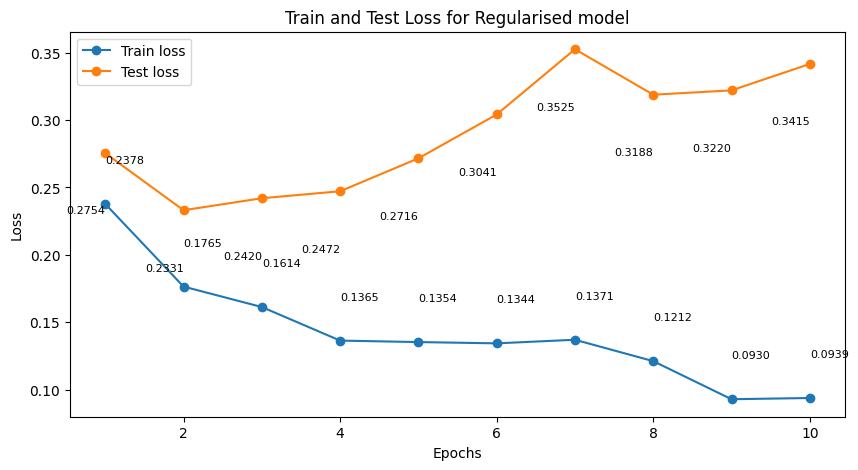

In [71]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

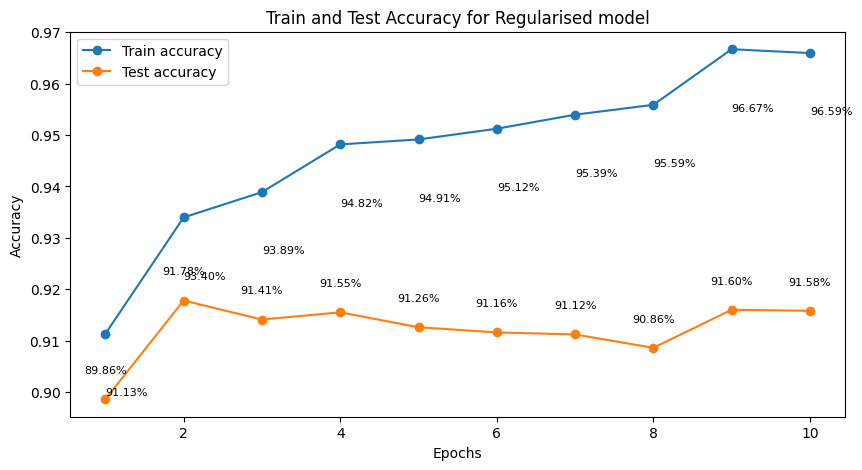

In [72]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [73]:
# Apply all regularisation techniques
train_loader, test_loader = load_fashionMNIST_data(augmentation=True)

model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.307878  [   32/60000]
loss: 0.886379  [ 3232/60000]
loss: 0.562363  [ 6432/60000]
loss: 0.654653  [ 9632/60000]
loss: 0.427555  [12832/60000]
loss: 1.074393  [16032/60000]
loss: 0.354589  [19232/60000]
loss: 0.358097  [22432/60000]
loss: 0.551510  [25632/60000]
loss: 0.760291  [28832/60000]
loss: 0.538105  [32032/60000]
loss: 0.348853  [35232/60000]
loss: 0.389813  [38432/60000]
loss: 0.554082  [41632/60000]
loss: 0.741822  [44832/60000]
loss: 0.237578  [48032/60000]
loss: 0.257593  [51232/60000]
loss: 0.499527  [54432/60000]
loss: 0.313911  [57632/60000]


Epochs:  10%|█         | 1/10 [00:53<07:59, 53.23s/it]

Train Error: 
 Accuracy: 87.0%, Avg loss: 0.343052 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.349100 

Epoch 2:

loss: 0.344705  [   32/60000]
loss: 0.302559  [ 3232/60000]
loss: 0.244496  [ 6432/60000]
loss: 0.433543  [ 9632/60000]
loss: 0.287437  [12832/60000]
loss: 0.542675  [16032/60000]
loss: 0.327542  [19232/60000]
loss: 0.294815  [22432/60000]
loss: 0.290997  [25632/60000]
loss: 0.546802  [28832/60000]
loss: 0.515298  [32032/60000]
loss: 0.322200  [35232/60000]
loss: 0.371926  [38432/60000]
loss: 0.175162  [41632/60000]
loss: 0.784229  [44832/60000]
loss: 0.302987  [48032/60000]
loss: 0.339519  [51232/60000]
loss: 0.475269  [54432/60000]
loss: 0.497960  [57632/60000]


Epochs:  20%|██        | 2/10 [01:52<07:32, 56.60s/it]

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.288042 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.298270 

Epoch 3:

loss: 0.237213  [   32/60000]
loss: 0.322690  [ 3232/60000]
loss: 0.264768  [ 6432/60000]
loss: 0.410119  [ 9632/60000]
loss: 0.068542  [12832/60000]
loss: 0.620133  [16032/60000]
loss: 0.308119  [19232/60000]
loss: 0.233947  [22432/60000]
loss: 0.205383  [25632/60000]
loss: 0.458285  [28832/60000]
loss: 0.465042  [32032/60000]
loss: 0.388078  [35232/60000]
loss: 0.251370  [38432/60000]
loss: 0.431063  [41632/60000]
loss: 0.645888  [44832/60000]
loss: 0.488399  [48032/60000]
loss: 0.105833  [51232/60000]
loss: 0.472635  [54432/60000]
loss: 0.361098  [57632/60000]


Epochs:  30%|███       | 3/10 [02:51<06:45, 57.86s/it]

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.261473 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.264760 

Epoch 4:

loss: 0.344565  [   32/60000]
loss: 0.257973  [ 3232/60000]
loss: 0.236270  [ 6432/60000]
loss: 0.338411  [ 9632/60000]
loss: 0.151564  [12832/60000]
loss: 0.448899  [16032/60000]
loss: 0.294888  [19232/60000]
loss: 0.266962  [22432/60000]
loss: 0.227390  [25632/60000]
loss: 0.510409  [28832/60000]
loss: 0.525587  [32032/60000]
loss: 0.318385  [35232/60000]
loss: 0.338447  [38432/60000]
loss: 0.369573  [41632/60000]
loss: 0.546594  [44832/60000]
loss: 0.119360  [48032/60000]
loss: 0.168896  [51232/60000]
loss: 0.438173  [54432/60000]
loss: 0.314153  [57632/60000]


Epochs:  40%|████      | 4/10 [03:46<05:39, 56.52s/it]

Train Error: 
 Accuracy: 91.1%, Avg loss: 0.237745 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.248133 

Epoch 5:

loss: 0.317093  [   32/60000]
loss: 0.212179  [ 3232/60000]
loss: 0.172520  [ 6432/60000]
loss: 0.599774  [ 9632/60000]
loss: 0.128171  [12832/60000]
loss: 0.502079  [16032/60000]
loss: 0.177494  [19232/60000]
loss: 0.259293  [22432/60000]
loss: 0.274714  [25632/60000]
loss: 0.316283  [28832/60000]
loss: 0.519277  [32032/60000]
loss: 0.351905  [35232/60000]
loss: 0.161162  [38432/60000]
loss: 0.297287  [41632/60000]
loss: 0.525941  [44832/60000]
loss: 0.404984  [48032/60000]
loss: 0.288757  [51232/60000]
loss: 0.378966  [54432/60000]
loss: 0.335746  [57632/60000]


Epochs:  50%|█████     | 5/10 [04:43<04:44, 56.86s/it]

Train Error: 
 Accuracy: 91.7%, Avg loss: 0.229375 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.240057 

Epoch 6:

loss: 0.211213  [   32/60000]
loss: 0.371489  [ 3232/60000]
loss: 0.293650  [ 6432/60000]
loss: 0.267969  [ 9632/60000]
loss: 0.102223  [12832/60000]
loss: 0.446610  [16032/60000]
loss: 0.166749  [19232/60000]
loss: 0.144823  [22432/60000]
loss: 0.278793  [25632/60000]
loss: 0.373572  [28832/60000]
loss: 0.522363  [32032/60000]
loss: 0.351951  [35232/60000]
loss: 0.250040  [38432/60000]
loss: 0.240426  [41632/60000]
loss: 0.365638  [44832/60000]
loss: 0.152626  [48032/60000]
loss: 0.299970  [51232/60000]
loss: 0.312447  [54432/60000]
loss: 0.170679  [57632/60000]


Epochs:  60%|██████    | 6/10 [05:36<03:41, 55.43s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.229951 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.252904 

Epoch 7:

loss: 0.314018  [   32/60000]
loss: 0.272543  [ 3232/60000]
loss: 0.342432  [ 6432/60000]
loss: 0.315561  [ 9632/60000]
loss: 0.095956  [12832/60000]
loss: 0.283861  [16032/60000]
loss: 0.231069  [19232/60000]
loss: 0.165141  [22432/60000]
loss: 0.253310  [25632/60000]
loss: 0.418265  [28832/60000]
loss: 0.524873  [32032/60000]
loss: 0.348328  [35232/60000]
loss: 0.260108  [38432/60000]
loss: 0.335113  [41632/60000]
loss: 0.307219  [44832/60000]
loss: 0.233400  [48032/60000]
loss: 0.206755  [51232/60000]
loss: 0.318909  [54432/60000]
loss: 0.436671  [57632/60000]


Epochs:  70%|███████   | 7/10 [06:28<02:43, 54.54s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.219487 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.240117 

Epoch 8:

loss: 0.248872  [   32/60000]
loss: 0.240710  [ 3232/60000]
loss: 0.242181  [ 6432/60000]
loss: 0.293629  [ 9632/60000]
loss: 0.078190  [12832/60000]
loss: 0.445243  [16032/60000]
loss: 0.282114  [19232/60000]
loss: 0.199096  [22432/60000]
loss: 0.350895  [25632/60000]
loss: 0.395117  [28832/60000]
loss: 0.572146  [32032/60000]
loss: 0.475550  [35232/60000]
loss: 0.183426  [38432/60000]
loss: 0.294946  [41632/60000]
loss: 0.480808  [44832/60000]
loss: 0.146573  [48032/60000]
loss: 0.417360  [51232/60000]
loss: 0.414024  [54432/60000]
loss: 0.321102  [57632/60000]


Epochs:  80%|████████  | 8/10 [07:21<01:48, 54.03s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.219179 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.236917 

Epoch 9:

loss: 0.268287  [   32/60000]
loss: 0.208815  [ 3232/60000]
loss: 0.248698  [ 6432/60000]
loss: 0.223315  [ 9632/60000]
loss: 0.086723  [12832/60000]
loss: 0.640913  [16032/60000]
loss: 0.230023  [19232/60000]
loss: 0.208335  [22432/60000]
loss: 0.300531  [25632/60000]
loss: 0.330334  [28832/60000]
loss: 0.369986  [32032/60000]
loss: 0.244693  [35232/60000]
loss: 0.217485  [38432/60000]
loss: 0.247042  [41632/60000]
loss: 0.363711  [44832/60000]
loss: 0.165997  [48032/60000]
loss: 0.164279  [51232/60000]
loss: 0.230213  [54432/60000]
loss: 0.202694  [57632/60000]


Epochs:  90%|█████████ | 9/10 [08:14<00:53, 53.67s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.219707 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.239479 

Epoch 10:

loss: 0.148140  [   32/60000]
loss: 0.336852  [ 3232/60000]
loss: 0.198202  [ 6432/60000]
loss: 0.280910  [ 9632/60000]
loss: 0.095104  [12832/60000]
loss: 0.637480  [16032/60000]
loss: 0.182291  [19232/60000]
loss: 0.156464  [22432/60000]
loss: 0.249394  [25632/60000]
loss: 0.227742  [28832/60000]
loss: 0.408118  [32032/60000]
loss: 0.363478  [35232/60000]
loss: 0.173199  [38432/60000]
loss: 0.205785  [41632/60000]
loss: 0.325205  [44832/60000]
loss: 0.251501  [48032/60000]
loss: 0.231298  [51232/60000]
loss: 0.376651  [54432/60000]
loss: 0.285738  [57632/60000]


Epochs: 100%|██████████| 10/10 [09:07<00:00, 54.70s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.215608 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.243848 

Done training!


Plotting metrics

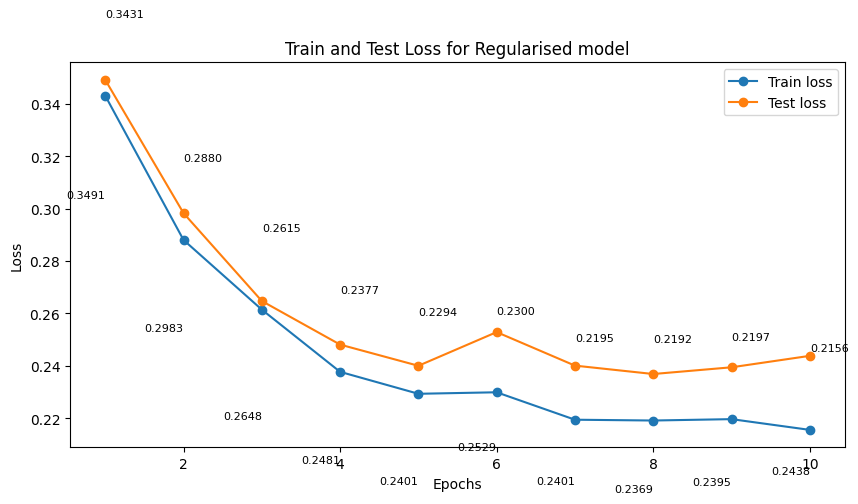

In [74]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

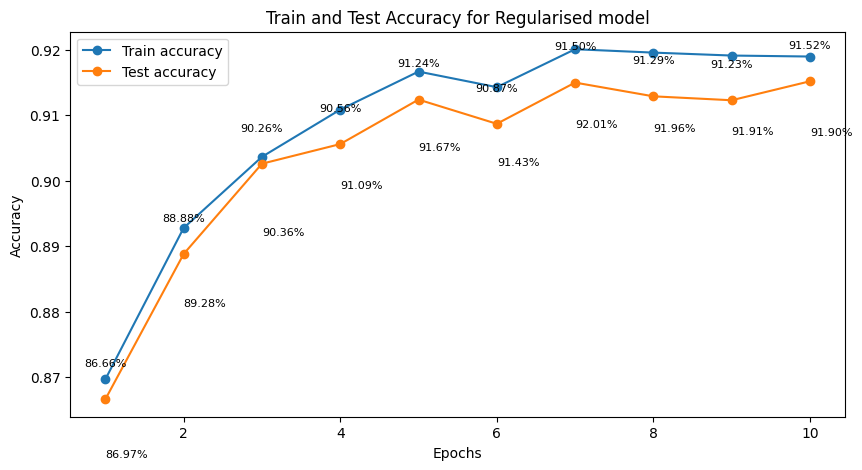

In [75]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

Without any regularisation techniques, the model performs notably better on the test set than on the train set (~5%). All three regularization techniques appear to close this gap and help the model overfit less to the train set, to different degrees.

Combining all three regularization techniques appears to product the single most generalized model, with less than half a percentage point inbetween its performance on the test and train set. Although we see higher test and train accuracies with the single-techique regularization model, the fact that the model does not overfit is valuable beyond a few percentage points worth of appeared performance.